# Transient simulation of a Jeffcott rotor in fixed bearings
    by Gerrit Nowald
Rotors can be found in many mechanical machines, such as jet engines, turbines and pumps. They often have complex dynamic behavior which can lead to undesired vibrations. This causes noise and can damage the machine. To improve this behavior, it is helpful to make a virtual model, with which the influence of different design parameters can be estimated without making many prototypes.
    
The Jeffcott or Laval rotor is the simplest model of a flexible rotor. It consists of a rigid disc on a massless, flexible shaft. Due to unbalance, the rotor is excited to vibrations, which are largest near the resonance rotation speed. Despite the simplicity, many real world dynamic behaviors of rotors can be shown with this model.

This notebooks shows a transient simulation of a run-up of with constant rotational acceleration, i.e. the rotation speed is increased linearly over time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

g = 9.81    # gravitational acceleration

## parameters

In [8]:
m   = 0.1       # mass of rotor / kg
eps = m*2e-5    # eccentricity of the center of mass / m (unbalance)
c   = 1e5       # shaft stiffness / N/m
d   = 1e-2*np.sqrt(c*m)     # damping coefficient / Ns/m (modal damping)

tmax = 2                         # max. time of calculation / s
fmax = 4*np.sqrt(c/m)/2/np.pi    # max rotational frequency / Hz (based on natural frequency)
arot = 2*np.pi*fmax/tmax         # acceleration of rotor speed / rad/s**2 (reach fmax in tmax)

## differential equations
The dynamic behavior of the rotor is described through a set of ordinary differential equations. To solve them numerically, they have to be transformed into state space, i.e. to differential equations with only first order derivates.

In [3]:
M = m*np.eye(2)   # mass matrix
D = d*np.eye(2)   # damping matrix
C = c*np.eye(2)   # stiffness matrix

def state_space(M,D,C):
    Minv = np.linalg.inv(M)
    A = np.vstack((      # state space matrix
        np.hstack(( np.zeros(np.shape(M)), np.eye(np.shape(M)[0]) )),
        np.hstack(( - Minv @ C, - Minv @ D )) ))
    return A, Minv

A, Minv = state_space(M,D,C)                # state space matrix
gvec    = g*np.hstack(( np.zeros(3), 1 ))   # gravity state space

def unbalance_const_acc(t,eps,arot):
    # unbalance forces
    alphad = arot*t
    alpha  = 0.5*arot*t**2
    FU = np.empty(2, dtype=np.float64)
    FU[0] = eps*( arot*np.cos(alpha) - alphad**2*np.sin(alpha) )    # horizontal
    FU[1] = eps*( arot*np.sin(alpha) + alphad**2*np.cos(alpha) )    # vertical
    return FU

def rotor_Jeffcott(t, q):
    FU   = unbalance_const_acc(t,eps,arot)       # unbalance forces
    fvec = np.hstack(( np.zeros(2), Minv @ FU )) # external forces state space
    return A @ q + fvec - gvec

## initial conditions
For the solution of the differential equations, initial conditions must be defined. They take the form q0 = [x, y, xd, yd].

In [4]:
q0 = np.linalg.solve(A, gvec)   # static equilibrium

## numerical integration
The differential equations are solved by integration, one step at a time, starting from the initial conditions.

In [5]:
res = solve_ivp(rotor_Jeffcott, [0, tmax], q0,
                t_eval = np.linspace(0, tmax, int(tmax**2*arot/2/np.pi*30) ),    # points of orbit at highest frequency
                rtol=1e-6, atol=1e-6 )

## plot results

- deflection over time:

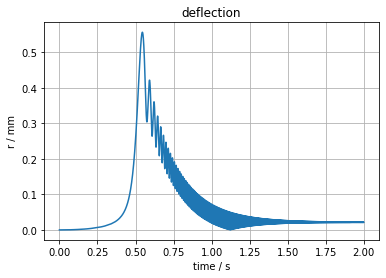

In [6]:
plt.plot(res.t, np.sqrt(res.y[0]**2+(res.y[1]-q0[1])**2)*1e3 )
plt.title("deflection")
plt.xlabel("time / s")
plt.ylabel("r / mm")
plt.grid()

- orbit:

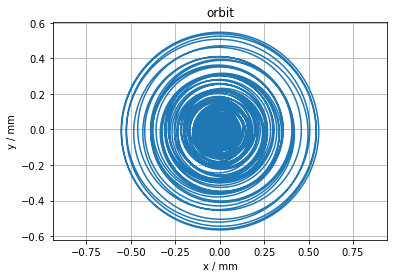

In [7]:
plt.plot(res.y[0]*1e3, res.y[1]*1e3 )
plt.title("orbit")
plt.xlabel("x / mm")
plt.ylabel("y / mm")
plt.axis('equal')
plt.grid()